# XGBoost Hyperparameter Tuning

Im vorherigen Notebook wurde XGBoost als eins der geeigneten Modelle identifiziert. In diesem Notebook wird nun das XGBoost-Modell optimiert.

In [1]:
from helper import *

df = load_merged_data(only_standard_refuelling=True)

In [2]:
import xgboost as xgb

In [3]:
input_columns = [
    'refuellingTimePoint', 'refuellingTimePoint_5', 'refuellingTimePoint_10', 'refuellingTimePoint_15', 'refuellingTimePoint_30', 'refuellingTimePoint_60',
    'bufferChargingDegree', 'bufferChargingDegree_5', 'bufferChargingDegree_10', 'bufferChargingDegree_15', 'bufferChargingDegree_30', 'bufferChargingDegree_60',
    'Anheizen', 'Anzünden', 'Ausbrennen', 'Ausgeschaltet', 'Automatik', 'Vorbelüften', 'Zündung bereit',
    'Year sin', 'Year cos',
    'refuellingQuantity',
    'residualOxygen', 'flueGasTemperature',
    'bufferTemperatureTop', 'bufferTemperatureMiddleTop', 'bufferTemperatureMiddle', 'bufferTemperatureMiddleBottom', 'bufferTemperatureBottom',
    'bufferUsableEnergyMax', 'bufferUsableEnergyActual',
    'outsideTemperature',
    'weatherTemperature', 'weatherWindX', 'weatherWindY',
    'weatherTemperature_6', 'weatherWindX_6', 'weatherWindY_6',
    'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12',
    'weatherTemperature_18', 'weatherWindX_18', 'weatherWindY_18',
    'weatherTemperature_24', 'weatherWindX_24', 'weatherWindY_24'
]

Im nächsten Schritt wird ein XGBoost-Modell trainiert. Dazu werden verschiedene Hyperparameter-Kombinationen ausprobiert und die beste Kombination ausgewählt.

Da aufgrund der Vielzahl an Parametern und deren verschiedenen möglichen Ausprägungen nicht alle Kombinationen getestet werden können, wird ein `RandomizedSearchCV` verwendet. Im Gegensatz zu `GridSearchCV` werden dabei zufällige Kombinationen ausgewählt und getestet. Die Anzahl der Kombinationen kann über den Parameter `n_iter` festgelegt werden.
Um die Güte zu bwerten wird auch hier auf `MAPE` und `SkipFirstTimeSeriesSplit` zurückgegriffen.   

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform

df_train, df_val = train_test_split(df, test_size=0.25, shuffle=False)
X_train, y_train = split_xy(df_train, input_columns)
X_val, y_val = split_xy(df_val, input_columns)

def custom_obj(y_true, y_pred):
    grad = 2 * y_pred / y_true - 2
    hess = 2 / y_true
    return grad, hess

model_params = {
    'eval_metric': 'mape',
}

xgb_model = xgb.XGBRegressor(**model_params)

param_distributions = {
    'objective': ['reg:squarederror', custom_obj],
    'n_estimators': randint(1000, 2000),
    'learning_rate': uniform(0.04, 0.1),
    'max_depth': randint(5, 20),
    'early_stopping_rounds': randint(1, 50)
    
} 

cv = SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2)

grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    verbose=2,
    n_jobs=1,
    return_train_score=True,
    error_score='raise',
    n_iter=30
)

grid_search.fit(X_train[::100], y_train[::100], eval_set=[(X_val, y_val)], verbose=False)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END early_stopping_rounds=46, learning_rate=0.08876023071425085, max_depth=9, n_estimators=1543, objective=reg:squarederror; total time=   7.2s
[CV] END early_stopping_rounds=46, learning_rate=0.08876023071425085, max_depth=9, n_estimators=1543, objective=reg:squarederror; total time=   6.8s
[CV] END early_stopping_rounds=46, learning_rate=0.08876023071425085, max_depth=9, n_estimators=1543, objective=reg:squarederror; total time=   8.1s
[CV] END early_stopping_rounds=20, learning_rate=0.08838399383180909, max_depth=7, n_estimators=1268, objective=reg:squarederror; total time=   3.4s
[CV] END early_stopping_rounds=20, learning_rate=0.08838399383180909, max_depth=7, n_estimators=1268, objective=reg:squarederror; total time=   3.5s
[CV] END early_stopping_rounds=20, learning_rate=0.08838399383180909, max_depth=7, n_estimators=1268, objective=reg:squarederror; total time=   4.2s
[CV] END early_stopping_rounds=47, learning_r

RandomizedSearchCV(cv=SkipFirstTimeSeriesSplit(gap=0, max_train_size=None, n_skip_splits=2,
             n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='mape',
                                          feature_t...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x151aecc90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x151afad90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15059b810>,
                                        'objective': ['reg:squarederror',
                                                      <function custom_obj at 0x151a77ba0>]},
                   return_train_score=True,
                   scoring='neg_mean_absolute_percentage_error', verbose=2)

Nach dem Training können die Parameterkombination nach dem besten `mean_test_score` sortiert werden, sodass die besten Parameter gefunden werden können.

In [5]:
result_df = pd.DataFrame(grid_search.cv_results_)
result_df = result_df[['params', 'mean_fit_time', 'mean_test_score', 'mean_train_score']]

# Umwandeln von negativen Werten in positive Werte
result_df['mean_test_score'] = -result_df['mean_test_score']
result_df['mean_train_score'] = -result_df['mean_train_score']

# Sortieren nach mean_test_score
result_df = result_df.sort_values(by='mean_test_score', ascending=True)

result_df

,params,mean_fit_time,mean_test_score,mean_train_score
10,"{'early_stopping_rounds': 6, 'learning_rate': ...",4.809969,0.256861,0.119615
21,"{'early_stopping_rounds': 42, 'learning_rate':...",10.987401,0.258101,0.102387
20,"{'early_stopping_rounds': 6, 'learning_rate': ...",6.166190,0.258770,0.137484
3,"{'early_stopping_rounds': 27, 'learning_rate':...",9.880926,0.259029,0.094933
28,"{'early_stopping_rounds': 29, 'learning_rate':...",9.179701,0.259693,0.133417
29,"{'early_stopping_rounds': 37, 'learning_rate':...",7.117376,0.259971,0.121941
4,"{'early_stopping_rounds': 21, 'learning_rate':...",6.047569,0.259997,0.094875
26,"{'early_stopping_rounds': 16, 'learning_rate':...",10.037879,0.260372,0.088305
5,"{'early_stopping_rounds': 21, 'learning_rate':...",11.485772,0.261148,0.076708
7,"{'early_stopping_rounds': 9, 'learning_rate': ...",7.030291,0.264074,0.075146


In [6]:
# print best parameters
grid_search.best_params_

{'early_stopping_rounds': 6,
 'learning_rate': 0.0706993781919538,
 'max_depth': 8,
 'n_estimators': 1139,
 'objective': <function __main__.custom_obj(y_true, y_pred)>}

# Finales Model

Mithilfe des Hyperparameter Tunings wurden die besten Parameter für das Modell gefunden.
Final kann nun dieses Modell noch einmal trainiert werden.

In [7]:
model_params = {
    'eval_metric': 'mape',
    'early_stopping_rounds': 50
}
model_params.update(grid_search.best_params_)

xgboostTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2),
    model_builder=lambda: xgb.XGBRegressor(**model_params), fit_params={'verbose': False}, generate_eval_set=True)
xgboostTrainer.cross_validation()

Finished fold
    Train Duration: 3.839944362640381 seconds
    Train Size: 35496
    MAPE: 0.22763671691142243
    MSE: 33.31402493861489
    RSME: 5.771830293642987
Finished fold
    Train Duration: 8.02832293510437 seconds
    Train Size: 47328
    MAPE: 0.23666790377124416
    MSE: 191.10578657435107
    RSME: 13.824101655237893
Finished fold
    Train Duration: 7.025547981262207 seconds
    Train Size: 59160
    MAPE: 0.2134967519430328
    MSE: 77.28616104137654
    RSME: 8.791254804712269
Average MAPE: 0.22593379087523313
Average MSE: 100.56865751811416
Average RSME: 10.028392569006968


0.22593379087523313

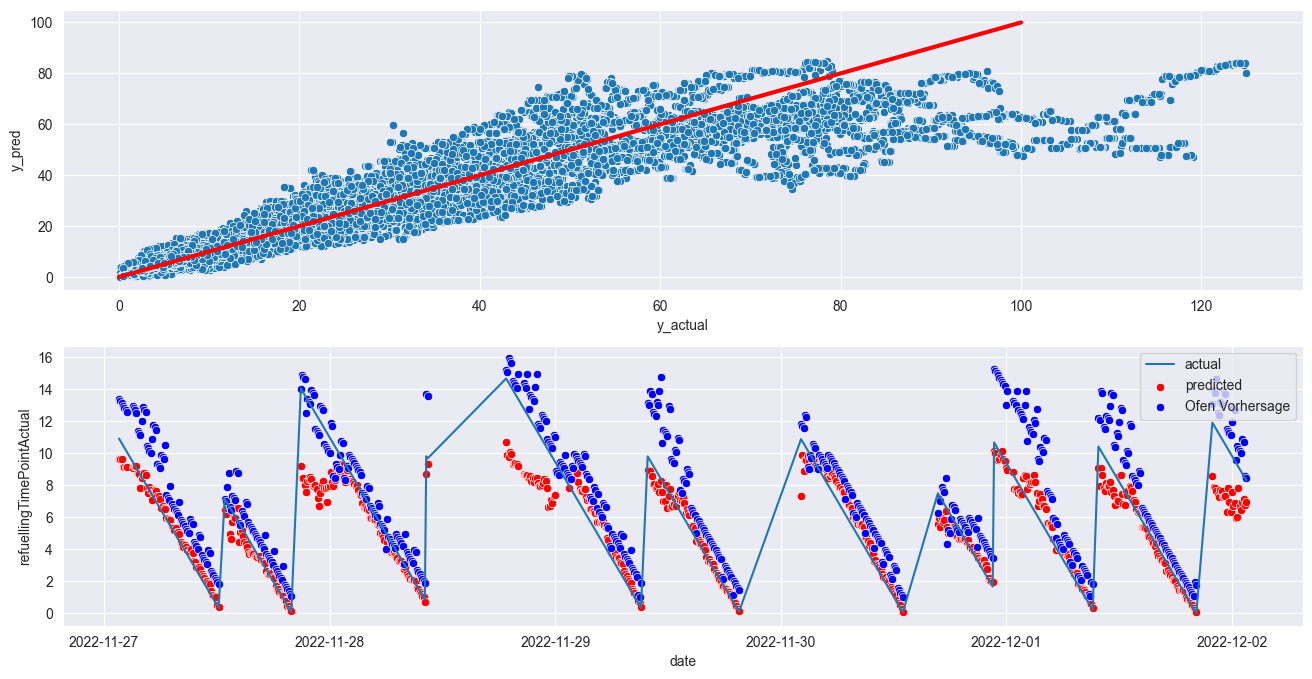

In [8]:
xgboostTrainer.visualize_split()

### Feature Importance

Um einen Einblick in die Funktionsweise des Modells zu erhalten, wird die Wichtigkeit der einzelnen Features betrachtet. Dazu wird die `plot_importance()` Methode von XGBoost verwendet. Diese gibt die Wichtigkeit der einzelnen Features als Bar Chart aus. Dabei wird die Wichtigkeit der Features in der Reihenfolge der Wichtigkeit absteigend sortiert.

Bei der Betrachtung der Feature Importance können einige Erkenntnisse gewonnen werden:
1. Als sehr wichtiges Feature wird die Vorhersage des Ofens selbst angegeben. Die Vorhersage des Ofens ist nicht überraschend, da dies bereits die Zielgröße vorhersagen soll.
2. Ebenfalls sehr wichtig wird die Jahreszeit (`Year sin` und `Year cos`) angegeben. Bereits in der Explorativen Datenanalyse wurde die starke Saisonalität der Daten festgestellt. Die Jahreszeit ist daher ein sehr wichtiges Feature.
3. Die Außentemperatur, die direkt von der Heizung gemessen wird (`outsideTemperature`), ist sehr viel relevanter als die Temperatur der historischen Wetterdaten (`weatherTemperature`).
4. Sowohl beim aktuellen Wetter als auch bei der Wettervorhersage ist die Temperatur sehr viel relevanter als der Wind.
5. Die Ofenzustände spielen nur eine geringe Rolle.
6. Bei den Werten zum aktuellen Brennvorgang ist die Abgastemperatur (`flueGasTemperature`) sehr relevant. Der Restsauerstoffgehalt (`residualOxygen`) ist jedoch sehr viel weniger relevant.

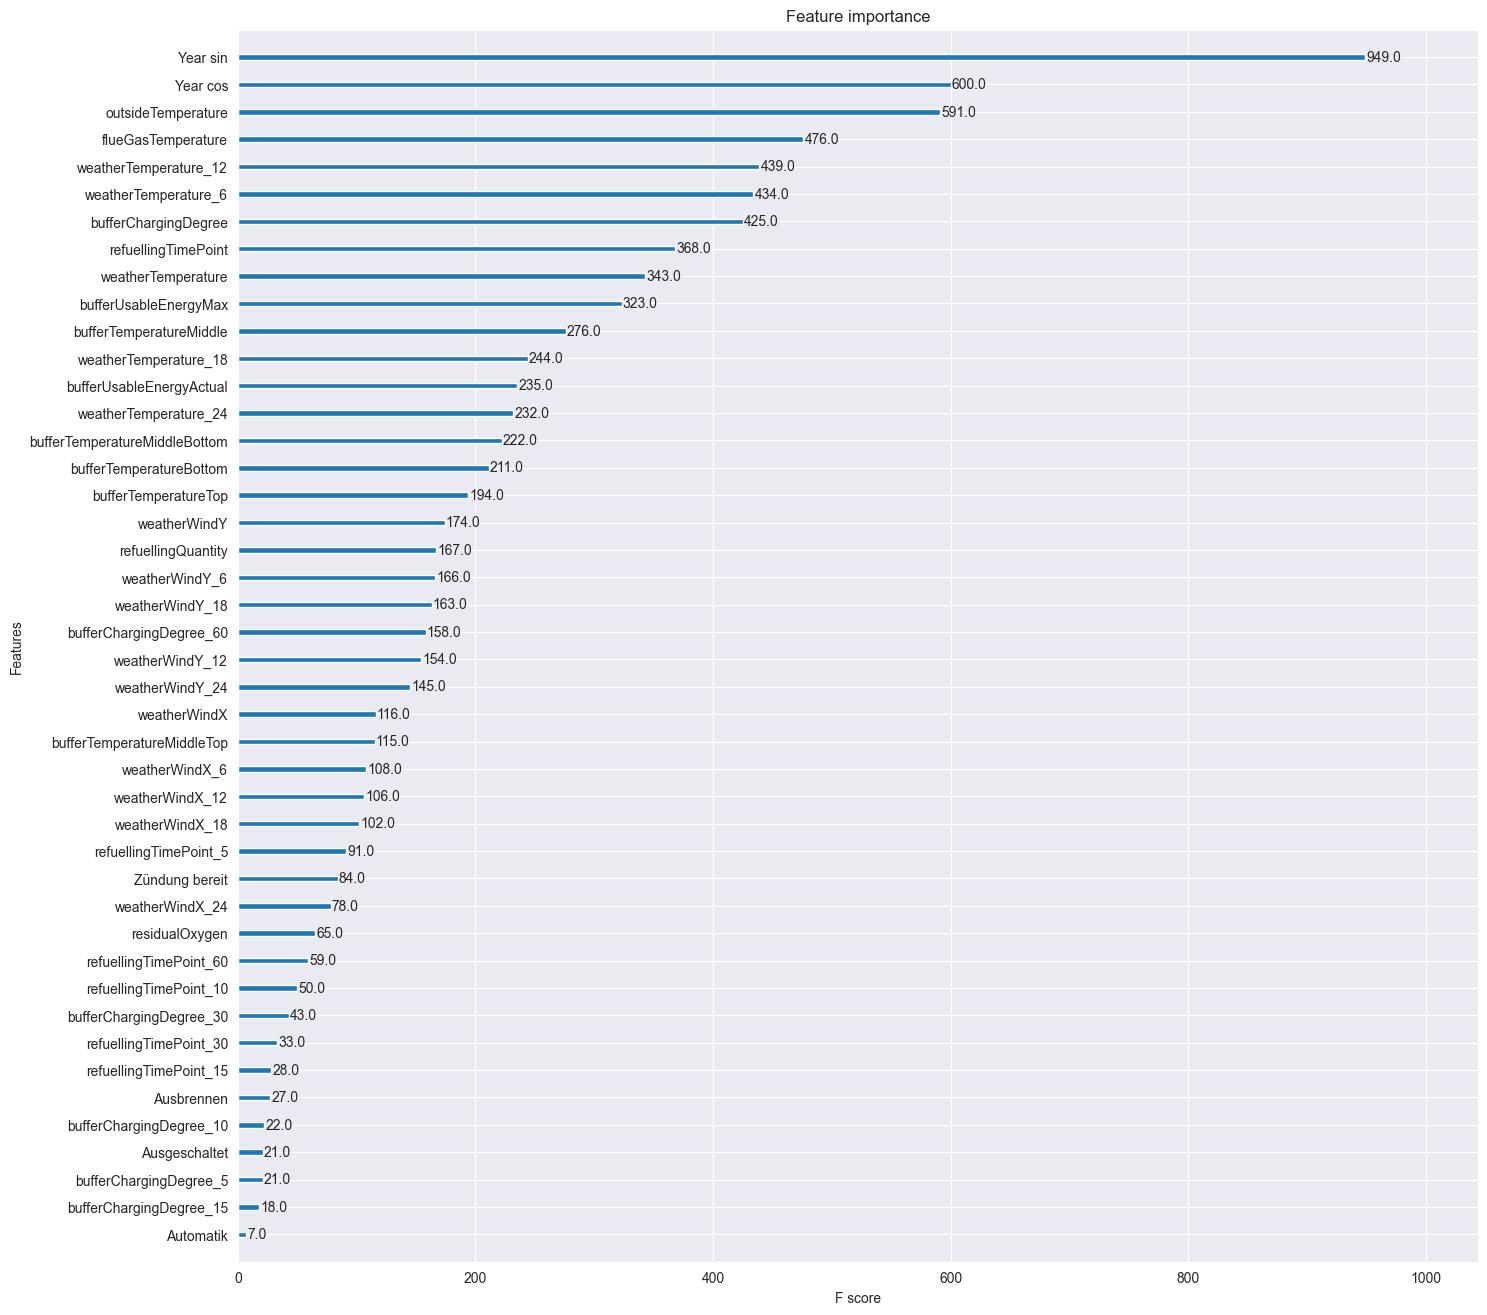

In [9]:
xgboostTrainer.train()
xgb.plot_importance(xgboostTrainer.model)
plt.gcf().set_size_inches(16, 16)
